**Import Dependencies**

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

**Load and Preprocess Data**

In [10]:

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')


customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

print("Data loaded successfully!")
print(f"Number of customers: {len(customers)}")
print(f"Number of transactions: {len(transactions)}")

Data loaded successfully!
Number of customers: 200
Number of transactions: 1000


**Feature Engineering**

In [11]:
def create_customer_features(customers, transactions):
    """customer features for clustering"""


    latest_date = transactions['TransactionDate'].max()
    customer_max_date = transactions.groupby('CustomerID')['TransactionDate'].max()
    recency = (latest_date - customer_max_date).dt.days


    frequency = transactions.groupby('CustomerID')['TransactionID'].count()

    monetary = transactions.groupby('CustomerID')['TotalValue'].sum()

    avg_transaction = transactions.groupby('CustomerID')['TotalValue'].mean()
    total_quantity = transactions.groupby('CustomerID')['Quantity'].sum()
    avg_quantity = transactions.groupby('CustomerID')['Quantity'].mean()

    feature_df = pd.DataFrame({
        'recency': recency,
        'frequency': frequency,
        'monetary': monetary,
        'avg_transaction': avg_transaction,
        'total_quantity': total_quantity,
        'avg_quantity': avg_quantity
    }).reset_index()

    customer_features = customers.merge(feature_df, on='CustomerID', how='left')

    region_dummies = pd.get_dummies(customer_features['Region'], prefix='region')
    customer_features = pd.concat([customer_features, region_dummies], axis=1)

    customer_features = customer_features.fillna(0)

    return customer_features

customer_features = create_customer_features(customers, transactions)

clustering_features = [
    'recency', 'frequency', 'monetary', 'avg_transaction',
    'total_quantity', 'avg_quantity'
] + [col for col in customer_features.columns if col.startswith('region_')]

X = customer_features[clustering_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features created successfully!")
print("\nFeatures used for clustering:")
print(clustering_features)

Features created successfully!

Features used for clustering:
['recency', 'frequency', 'monetary', 'avg_transaction', 'total_quantity', 'avg_quantity', 'region_Asia', 'region_Europe', 'region_North America', 'region_South America']


**Find Optimal Number of Clusters**

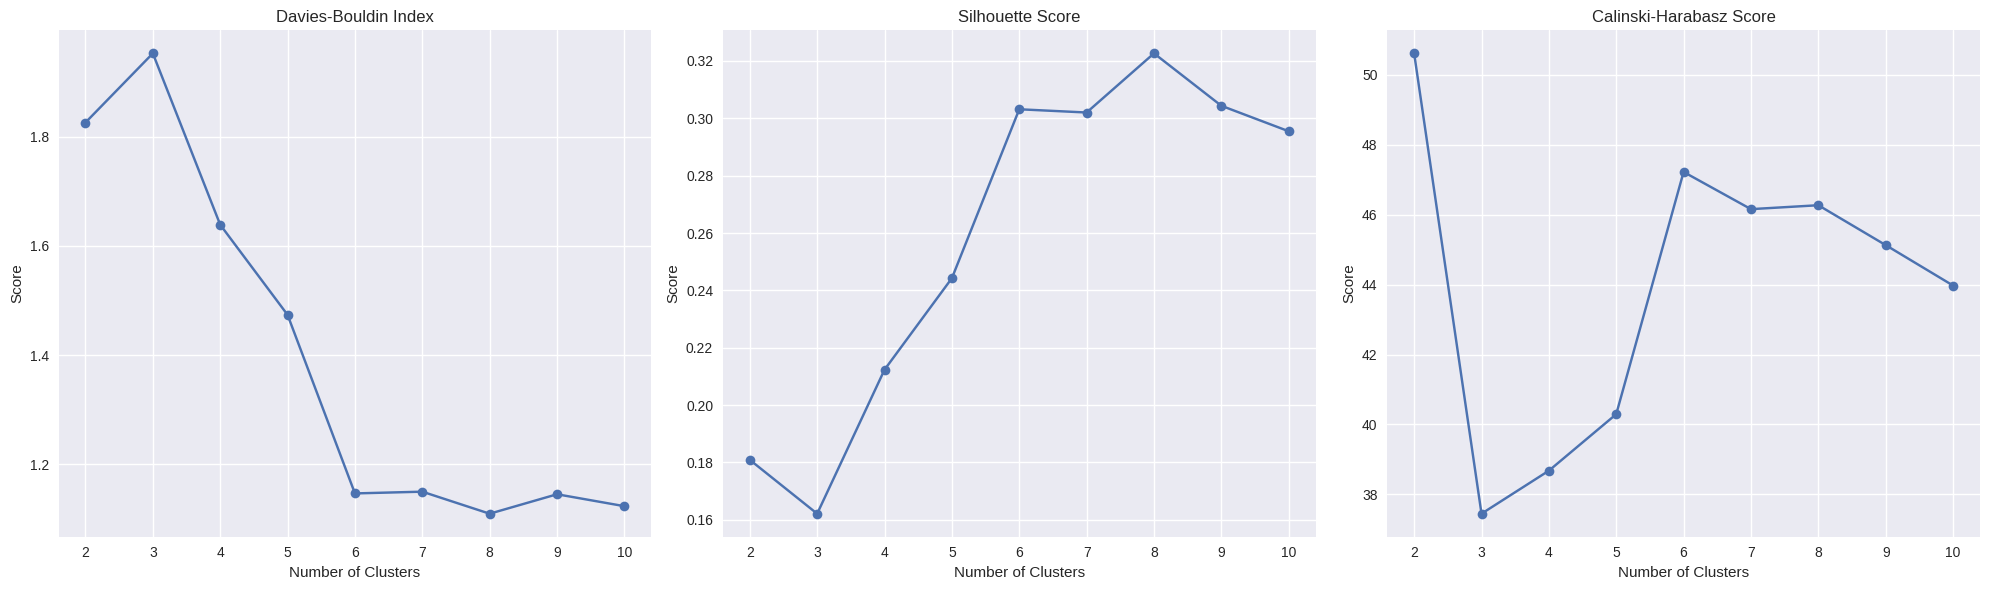


Optimal number of clusters based on Davies-Bouldin Index: 8

Clustering metrics for all configurations:
   n_clusters  db_index  silhouette   calinski
0           2  1.826301    0.180882  50.611025
1           3  1.953100    0.162106  37.448445
2           4  1.638971    0.212333  38.678287
3           5  1.473780    0.244255  40.294163
4           6  1.146461    0.303162  47.220139
5           7  1.149651    0.302032  46.156598
6           8  1.109280    0.322666  46.268456
7           9  1.144915    0.304380  45.128414
8          10  1.123067    0.295493  43.972090


In [12]:

cluster_metrics = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    db_index = davies_bouldin_score(X_scaled, labels)
    silhouette = silhouette_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)

    cluster_metrics.append({
        'n_clusters': n_clusters,
        'db_index': db_index,
        'silhouette': silhouette,
        'calinski': calinski
    })

metrics_df = pd.DataFrame(cluster_metrics)


fig, axes = plt.subplots(1, 3, figsize=(20, 6))


axes[0].plot(metrics_df['n_clusters'], metrics_df['db_index'], marker='o')
axes[0].set_title('Davies-Bouldin Index')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Score')

axes[1].plot(metrics_df['n_clusters'], metrics_df['silhouette'], marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Score')

axes[2].plot(metrics_df['n_clusters'], metrics_df['calinski'], marker='o')
axes[2].set_title('Calinski-Harabasz Score')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

optimal_n_clusters = metrics_df.loc[metrics_df['db_index'].idxmin(), 'n_clusters']
print(f"\nOptimal number of clusters based on Davies-Bouldin Index: {optimal_n_clusters}")
print("\nClustering metrics for all configurations:")
print(metrics_df)

**Perform Clustering with Optimal Number**

In [13]:

kmeans = KMeans(n_clusters=int(optimal_n_clusters), random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=clustering_features
)

cluster_sizes = customer_features['Cluster'].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)

cluster_profiles = customer_features.groupby('Cluster')[clustering_features].mean()
print("\nCluster profiles:")
print(cluster_profiles)


Cluster sizes:
Cluster
0    10
1    35
2    38
3    39
4    18
5    12
6    24
7    24
Name: count, dtype: int64

Cluster profiles:
            recency  frequency     monetary  avg_transaction  total_quantity  \
Cluster                                                                        
0         23.600000   9.200000  6550.715000       720.441537       24.900000   
1         69.428571   4.171429  2510.836286       595.667989        9.457143   
2         85.105263   4.842105  2992.202895       655.122363       11.578947   
3         73.948718   4.589744  3383.850256       756.020251       11.923077   
4         58.444444   7.500000  5379.353889       736.287599       19.611111   
5        150.250000   2.166667   691.478333       266.112111        3.166667   
6         73.958333   3.333333  2263.994583       727.445556        8.458333   
7         53.750000   6.583333  5478.053750       853.791925       19.083333   

         avg_quantity  region_Asia  region_Europe  region_North Am

**Visualize Clusters**

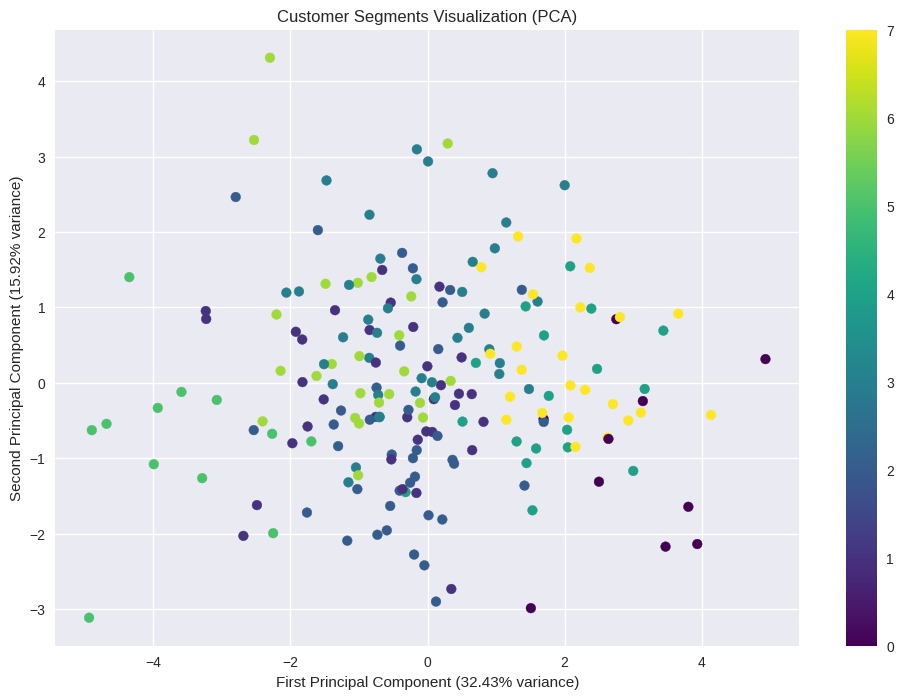

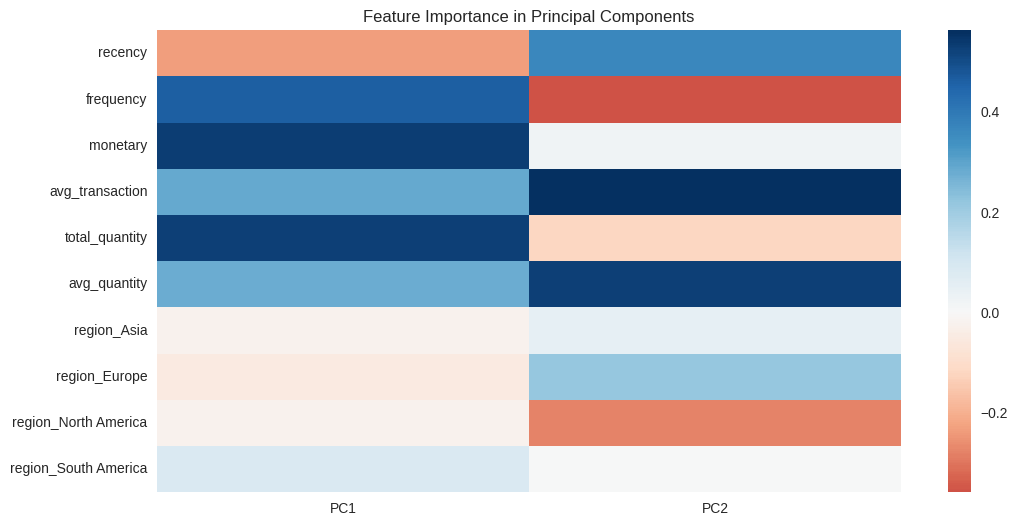

In [14]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

viz_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
viz_df['Cluster'] = customer_features['Cluster']

plt.figure(figsize=(12, 8))
scatter = plt.scatter(viz_df['PC1'], viz_df['PC2'],
                     c=viz_df['Cluster'],
                     cmap='viridis')
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter)
plt.show()

feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=clustering_features
)

plt.figure(figsize=(12, 6))
sns.heatmap(feature_importance, cmap='RdBu', center=0)
plt.title('Feature Importance in Principal Components')
plt.show()

**Cluster Insights**

In [15]:

cluster_insights = []
for cluster in range(int(optimal_n_clusters)):
    cluster_data = customer_features[customer_features['Cluster'] == cluster]

    insight = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Size_Percentage': len(cluster_data) / len(customer_features) * 100,
        'Avg_Monetary': cluster_data['monetary'].mean(),
        'Avg_Frequency': cluster_data['frequency'].mean(),
        'Avg_Recency': cluster_data['recency'].mean(),
        'Top_Region': cluster_data['Region'].mode().iloc[0]
    }
    cluster_insights.append(insight)

insights_df = pd.DataFrame(cluster_insights)
print("\nCluster Insights:")
print(insights_df)

results = {
    'optimal_clusters': int(optimal_n_clusters),
    'db_index': metrics_df.loc[metrics_df['n_clusters'] == optimal_n_clusters, 'db_index'].iloc[0],
    'silhouette': metrics_df.loc[metrics_df['n_clusters'] == optimal_n_clusters, 'silhouette'].iloc[0],
    'calinski': metrics_df.loc[metrics_df['n_clusters'] == optimal_n_clusters, 'calinski'].iloc[0]
}

customer_features[['CustomerID', 'Cluster']].to_csv('FirstName_LastName_Clustering.csv', index=False)

print("\nFinal Clustering Results:")
print(f"Number of clusters: {results['optimal_clusters']}")
print(f"Davies-Bouldin Index: {results['db_index']:.4f}")
print(f"Silhouette Score: {results['silhouette']:.4f}")
print(f"Calinski-Harabasz Score: {results['calinski']:.4f}")


Cluster Insights:
   Cluster  Size  Size_Percentage  Avg_Monetary  Avg_Frequency  Avg_Recency  \
0        0    10              5.0   6550.715000       9.200000    23.600000   
1        1    35             17.5   2510.836286       4.171429    69.428571   
2        2    38             19.0   2992.202895       4.842105    85.105263   
3        3    39             19.5   3383.850256       4.589744    73.948718   
4        4    18              9.0   5379.353889       7.500000    58.444444   
5        5    12              6.0    691.478333       2.166667   150.250000   
6        6    24             12.0   2263.994583       3.333333    73.958333   
7        7    24             12.0   5478.053750       6.583333    53.750000   

      Top_Region  
0  North America  
1  South America  
2  North America  
3         Europe  
4           Asia  
5         Europe  
6           Asia  
7  South America  

Final Clustering Results:
Number of clusters: 8
Davies-Bouldin Index: 1.1093
Silhouette Score: 0.